In [44]:
%pylab inline
from sklearn.svm import SVDD
from sklearn.metrics import pairwise_distances
import pandas as pd
from random import sample
import sys
import os
from sklearn.cross_validation import KFold
from scipy.linalg import cholesky
from sklearn.cross_validation import train_test_split 
from sklearn.metrics import roc_auc_score
from sklearn.utils import check_random_state
from scipy.spatial import cKDTree
from sklearn.utils import array2d
import time
nu = 0.1

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


#### Data generation functions

In [2]:
def SMOTE(X, n_samples, k=5, dist_power=2, multiple=False, sample_weight=None,
          random_state=None):
    """
    Returns n_samples of synthetic samples from X generated by SMOTE.

    Parameters
    ----------
    X : array-like, shape = [n_minority_samples, n_features]
        Holds the minority samples
    n_samples : int
        Number of new synthetic samples.
    k : int
        Number of nearest neighbours.
    dist_power : float, int
        Positive power in ditance metrics.
    random_state : None or int
        Seed for random generator.


    Returns
    -------
    smoted_X : array, shape = [n_samples, n_features]
        Synthetic samples
    """
    
    if type(X) is pd.core.frame.DataFrame:
        X = X.values

    rng = check_random_state(random_state)
    n_minor, n_features = X.shape
    k = min([n_minor - 1, k])

    # Learn nearest neighbours
    nn_tree = cKDTree(X)

    if multiple:
        smoted_X = X.copy()
        if sample_weight is not None:
            weight_smoted = sample_weight.copy()
        nn_dist, nn_idx = nn_tree.query(smoted_X, k=k + 1, p=dist_power)
        nn_idx = nn_idx[:, 1:]
        for i in xrange(n_samples):
            start_idx = rng.choice(len(smoted_X))
            start = smoted_X[start_idx, :]
            end_idx = nn_idx[start_idx, rng.choice(k)]
            end = smoted_X[end_idx, :]
            shift = rng.rand()
            new_point = [start * shift + end * (1. - shift)]
            new_nn_idx = np.argsort(
                distance_matrix(smoted_X, new_point,
                                p=dist_power).T)[::-1][0][:k]
            smoted_X = np.vstack((smoted_X, new_point))
            nn_idx = np.vstack((nn_idx, new_nn_idx))
            if sample_weight is not None:
                weight_smoted = \
                    np.concatenate((weight_smoted,
                                    weight_smoted[start_idx] * shift +
                                    (1. - shift) * weight_smoted[end_idx]))

    else:
        start_indices = rng.choice(len(X), size=(n_samples,))
        starts = X[start_indices, :]
        nn_dists, nn_idx = nn_tree.query(starts, k=k + 1, p=dist_power)
        end_indices = nn_idx[np.arange(n_samples),
                             rng.choice(np.arange(1, k + 1), n_samples)]
        ends = X[end_indices, :]
        shifts = rng.rand(n_samples)
        smoted_X = starts * np.repeat(array2d(shifts).T, n_features, axis=1) \
            + ends * np.repeat(array2d(1. - shifts).T, n_features, axis=1)
        smoted_X = np.vstack((X, smoted_X))
        if sample_weight is not None:
            weight_smoted = sample_weight[start_indices] * shifts\
                + (1. - shifts) * sample_weight[end_indices]
    if sample_weight is None:
        return smoted_X
    else:
        return smoted_X, np.concatenate((sample_weight, weight_smoted))

In [3]:
def generate_synthetic_data(size, dim=2, centroid_count=2, centroid_dispersion=1):
    size = int(size)
    centroids = np.random.rand(centroid_count, dim) * 10 - 5
    all_data_part = []
    for point in centroids:
        covariation_matrix = np.random.randn(dim, dim)
        covariation_matrix = np.dot(covariation_matrix, covariation_matrix.T)
        covariation_matrix = cholesky(covariation_matrix)
        data_part = np.random.randn(int(size / centroid_count), dim)
        data_part = np.dot(data_part, covariation_matrix) + point
        all_data_part.append(data_part)
    data = np.concatenate(all_data_part, axis=0)
    return data

In [4]:
def generate_outlier(size, dim=2, space=1000):
    size = int(size)
    outliers = (np.random.rand(size, dim) - 0.5) * space * 2
    return outliers

In [5]:
def generate_dataset(size, outliers_part=0.12, dim=2, centroid_count=2, centroid_dispersion=1):
    inliers = generate_synthetic_data(size * (1 - outliers_part), 
                                               dim, centroid_count, 
                                               centroid_dispersion)
    outliers = generate_outlier(size*outliers_part, dim, space=centroid_dispersion*50)
    data = np.concatenate([inliers, outliers], axis=0)
    data = pd.DataFrame(data)
    data['label'] = ['target'] * len(inliers) + ['outlier'] * len(outliers)
    return data

#### Risk calculation functions

In [6]:
def validate_classifier_by_random_points(clf, train_x, size=10000):
    clf.fit(train_x)
    positive_points = SMOTE(train_x, k=5,n_samples=size)
    negative_points = np.random.rand(size, train_x.shape[1])
    negative_points *= np.std(train_x)
    error = mean(clf.predict(positive_points) == -1)
    error += mean(clf.predict(negative_points) == 1)
    return error

In [7]:
def rbf_kernel(X, Y, gamma):
    distance_matrix = pairwise_distances(X, Y) ** 2
    #print "Gamma = ", gamma
    distance_matrix = exp(-1 * gamma * distance_matrix)
    return distance_matrix

In [8]:
def calculate_radius(clf):
    all_support_vectors = clf.support_vectors_
    first_support_vector = clf.support_vectors_[0, :]
    dual_coef = clf.dual_coef_
    gamma = clf.gamma
    test_vector_norm = 1
    second_part = rbf_kernel(all_support_vectors, first_support_vector, gamma)
    #print "second_vector", second_part
    second_part = dot(dual_coef, second_part)
    #print second_part
    third_part = dot(dual_coef, dot(rbf_kernel(all_support_vectors, all_support_vectors, gamma), dual_coef.T))[0, 0]
    radius = (test_vector_norm - 2 * second_part + third_part)
    return radius[0, 0]

In [9]:
clf = SVDD(kernel='rbf', gamma=1).fit(train_x)
calculate_radius(clf)

NameError: name 'train_x' is not defined

In [10]:
rbf_kernel(support_vectors[0, :], support_vectors[1, :], clf.gamma)

NameError: name 'support_vectors' is not defined

In [34]:
def combinatorial_dimension_metric(clf, train_x):
    clf.fit(train_x)
    prediction = clf.decision_function(train_x)
    negative_marks = prediction < 0
    prediction = prediction[negative_marks]
    distance = prediction.min()
    radius = calculate_radius(clf)
    radius += abs(distance)
    return abs(distance) / radius
    
    
train_x = randn(100, 2)
clf = SVDD(kernel='rbf', gamma=0.001).fit(train_x)
combinatorial_dimension_metric(clf, train_x)

0.030530754808307945

In [12]:
def kernel_metric(clf, train_x):
    gamma = clf.gamma
    distance = pairwise_distances(train_x)
    distance = distance * distance
    kernel_matrix = exp(-gamma * distance)
    kernel_matrix -= eye(kernel_matrix.shape[0])
    reguarization = 0.001
    return -var(kernel_matrix) / (mean(kernel_matrix) + reguarization)

In [29]:
def support_vectors_metric(clf, train_x):
    clf.fit(train_x)
    prediction = clf.predict(train_x)
    out_of_class_fraction = mean(prediction == -1)
    support_vectors_fraction = float(len(clf.support_vectors_)) / len(train_x)
    metric = (out_of_class_fraction - nu) ** 2
    metric += (support_vectors_fraction - nu) ** 2
    return metric

In [14]:
def slice_probability_space_metric(clf, train_x, folds_count=7):
    kf_iterator = KFold(len(data), n_folds=folds_count)
    metric = 0.0
    for train, test in kf_iterator:
        train_data = train_x[train,:]
        test_data = train_x[test,:]
        clf.fit(train_data)
        prediction = clf.predict(test_data)
        inlier_metric_part = mean(prediction == -1)
        inlier_metric_part = inlier_metric_part / (1 + rho) / len(data)
        outliers = outlier_distribution(*data.shape) - 0.5
        outliers *= 8 * np.std(train_x)
        outlier_metric_part = mean(clf.predict(outliers) == 1) * rho / (1 + rho) / len(outliers)
        metric += inlier_metric_part + outlier_metric_part
    return metric / folds_count

#### Selection function

In [15]:
all_gammas = np.logspace(-10, 10, 20)
def model_selection(data, all_gammas, selection_technic):
    metrics = zeros(all_gammas.shape[0])
    for index, gamma in enumerate(all_gammas):
        clf = SVDD(C = 1.0 / 100, gamma=gamma, kernel='rbf')
        metrics[index] = selection_technic(clf, data)
    return metrics

#### Example

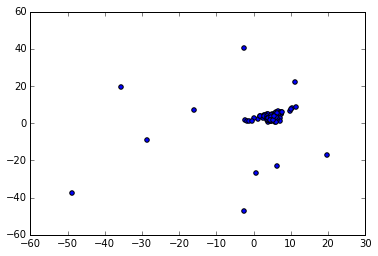

In [16]:
synthetic_data = generate_dataset(100, centroid_count=2, outliers_part=0.1)
scatter(synthetic_data.iloc[:, 0], synthetic_data.iloc[:, 1])

In [17]:
all_gammas = np.logspace(-7, 7, 50)
metrics = model_selection(synthetic_data.iloc[:, :-1], all_gammas, kernel_metric)

In [18]:
print all_gammas

[  1.00000000e-07   1.93069773e-07   3.72759372e-07   7.19685673e-07
   1.38949549e-06   2.68269580e-06   5.17947468e-06   1.00000000e-05
   1.93069773e-05   3.72759372e-05   7.19685673e-05   1.38949549e-04
   2.68269580e-04   5.17947468e-04   1.00000000e-03   1.93069773e-03
   3.72759372e-03   7.19685673e-03   1.38949549e-02   2.68269580e-02
   5.17947468e-02   1.00000000e-01   1.93069773e-01   3.72759372e-01
   7.19685673e-01   1.38949549e+00   2.68269580e+00   5.17947468e+00
   1.00000000e+01   1.93069773e+01   3.72759372e+01   7.19685673e+01
   1.38949549e+02   2.68269580e+02   5.17947468e+02   1.00000000e+03
   1.93069773e+03   3.72759372e+03   7.19685673e+03   1.38949549e+04
   2.68269580e+04   5.17947468e+04   1.00000000e+05   1.93069773e+05
   3.72759372e+05   7.19685673e+05   1.38949549e+06   2.68269580e+06
   5.17947468e+06   1.00000000e+07]


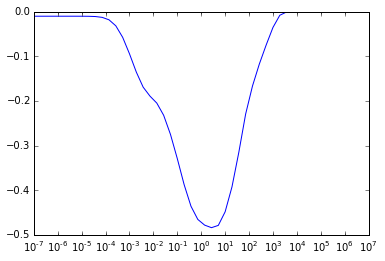

In [19]:
plot(all_gammas, metrics)
xscale('log')

#### World's data processing

In [20]:
def split_anomaly_normal_data(data, outliers_fraction=0.1):
    outliers = data.query("label == 'outlier'")
    inliers = data.query("label == 'target'")
    outliers_count = int(len(inliers) * outliers_fraction / (1 - outliers_fraction))
    if outliers_count > len(outliers):
        raise ValueError("There are no so many outliers")
    outliers_rows = sample(outliers.index, outliers_count)
    selected_outliers = outliers.ix[outliers_rows]
    return inliers.iloc[:, :-1], selected_outliers.iloc[:, :-1]

In [21]:
def split_data_set(data, parts_count=3):
    all_parts = []
    kfold =KFold(len(data), n_folds=parts_count)
    for train, test in kfold:
        all_parts.append(data.iloc[test, :])
    return all_parts

#### Example

In [22]:
data = pd.read_csv('./csv_data_set/Iris (targetcl. Iris-setosa).csv')

In [23]:
metrics = model_selection(data.iloc[:, :-1], all_gammas, kernel_metric)

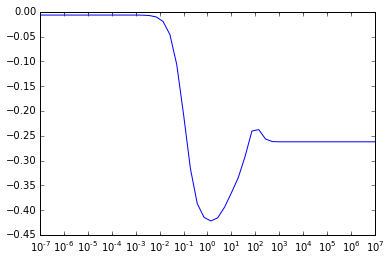

In [24]:
plot(all_gammas, metrics)
xscale('log')

#### Loading all data sets

In [25]:
def save_fig(all_gammas, metric, name):
    fig = figure()
    plot(all_gammas, metric)
    xscale('log')
    xlabel(r'$\gamma$')
    ylabel('metric')
    print name
    savefig(name)

#### Calculating metrics for every dataset

In [41]:
def validate_gamma(train, test_normal, test_anomaly, gamma):
    C = 1.0 / (0.1 * (len(train)))
    clf = SVDD(kernel='rbf', gamma=gamma, C=C)
    #clf.fit(np.random.randn(10000, 4))
    clf.fit(train)
    normal_data_prediction = clf.decision_function(test_normal)
    anomaly_data_prediction = clf.decision_function(test_anomaly)
    normal_data_error = np.mean(normal_data_prediction < 0)
    anomaly_data_error = np.mean(anomaly_data_prediction > 0)
    true_labels = [1] * len(test_normal) + [-1] * len(test_anomaly)
    decision_values = np.concatenate([normal_data_prediction, anomaly_data_prediction], axis=0)
    auc_score = roc_auc_score(true_labels, decision_values)
    return normal_data_error, anomaly_data_error, auc_score

In [46]:
def process_data_set(data):
    normal_data, anomaly_data = split_anomaly_normal_data(data)
    selection_technics = [validate_classifier_by_random_points, kernel_metric, support_vectors_metric, combinatorial_dimension_metric]
    normal_train, normal_validate, normal_test = split_data_set(normal_data, 3)
    anomaly_train, anomaly_validate, anomaly_test = split_data_set(anomaly_data, 3)
    results = {}
    all_gammas = np.logspace(-10, 10, 50)
    for technic in selection_technics:
        start = time.time()
        metrics = model_selection(concatenate([normal_validate, anomaly_validate]), all_gammas, technic)
        duration = time.time() - start
        best_index = np.argmin(metrics)
        best_score = metrics[best_index]
        all_best_gamma = metrics == best_score
        possible_results = all_gammas[all_best_gamma]
        best_gamma = np.max(possible_results)
        fn, fp, auc = validate_gamma(concatenate([normal_train, anomaly_train]), normal_test, anomaly_test, best_gamma)
        results[str(technic).split()[1]] = {'false negative': fn, 'false positive': fp, 'auc': auc, 'time':duration}
    return results

In [50]:
size = 1000
results = {}
for k in range(1, 15):
    for n in range(2, 30, 3):
        data = generate_dataset(size, dim=n, centroid_count=k)
        tmp = process_data_set(data)
        print tmp
        results["k = {}, n = {}".format(k, n)] = tmp
        print "k = {}".format(k), "n = {}".format(n)

{'support_vectors_metric': {'false positive': 0.0, 'auc': 1.0, 'false negative': 0.058020477815699661, 'time': 0.24587798118591309}, 'validate_classifier_by_random_points': {'false positive': 0.0, 'auc': 0.99989334470989766, 'false negative': 0.058020477815699661, 'time': 7.271494150161743}, 'kernel_metric': {'false positive': 0.0, 'auc': 1.0, 'false negative': 0.66552901023890787, 'time': 0.22919416427612305}, 'combinatorial_dimension_metric': {'false positive': 0.0, 'auc': 0.98976109215017072, 'false negative': 0.92150170648464169, 'time': 0.34679603576660156}}
k = 1 n = 2
{'support_vectors_metric': {'false positive': 0.0, 'auc': 1.0, 'false negative': 1.0, 'time': 0.28898096084594727}, 'validate_classifier_by_random_points': {'false positive': 0.0, 'auc': 1.0, 'false negative': 0.48805460750853241, 'time': 11.236037015914917}, 'kernel_metric': {'false positive': 0.0, 'auc': 1.0, 'false negative': 0.20819112627986347, 'time': 0.24857306480407715}, 'combinatorial_dimension_metric': {'

In [365]:
normal_data = np.random.randn(1000, 2)
anomaly_data = np.random.randn(10, 2) - 0.5
anomaly_data *= 50
labels = ['Target'] * 1000 + ['Outlier'] * 10
data = np.concatenate([normal_data, anomaly_data], axis=0)

data = pd.DataFrame(data)

In [367]:
data['labels'] = labels

In [368]:
data

,0,1,labels
0,-0.374272,-0.037361,Target
1,-0.045418,0.310972,Target
2,-1.387510,-0.151845,Target
3,0.802772,-0.787596,Target
4,-1.602887,-0.754612,Target
5,-1.073942,-0.489661,Target
6,-0.085912,0.758856,Target
7,-0.562779,-1.472338,Target
8,-1.589580,-1.984523,Target
9,-1.157671,-0.025991,Target


In [31]:
results

{'k = 1, n = 11': {'kernel_metric': {'auc': 0.99981116735293352,
   'false negative': 0.11524036822366178,
   'false positive': 0.0,
   'time': 10.858461856842041},
  'support_vectors_metric': {'auc': 0.96396863279918177,
   'false negative': 0.38765768837367881,
   'false positive': 0.0,
   'time': 0.3508949279785156},
  'validate_classifier_by_random_points': {'auc': 0.51261506989430616,
   'false negative': 1.0,
   'false positive': 0.0,
   'time': 5.917889833450317}},
 'k = 1, n = 14': {'kernel_metric': {'auc': 0.99912717354244795,
   'false negative': 0.200818274803955,
   'false positive': 0.0,
   'time': 11.046540975570679},
  'support_vectors_metric': {'auc': 0.85313645781426217,
   'false negative': 0.45414251619502216,
   'false positive': 0.027692307692307693,
   'time': 0.39176297187805176},
  'validate_classifier_by_random_points': {'auc': 0.99936741063232715,
   'false negative': 1.0,
   'false positive': 0.0,
   'time': 11.152853965759277}},
 'k = 1, n = 17': {'kernel_me

In [43]:
results_previous = results

In [47]:
results

{'k = 1, n = 11': {'kernel_metric': {'auc': 0.99998426394607776,
   'false negative': 0.12376406409819297,
   'false positive': 0.0,
   'time': 26.952219009399414},
  'support_vectors_metric': {'auc': 0.5,
   'false negative': 1.0,
   'false positive': 0.0,
   'time': 0.8779561519622803},
  'validate_classifier_by_random_points': {'auc': 0.99491515644260275,
   'false negative': 0.10126150698943062,
   'false positive': 0.0030769230769230769,
   'time': 18.51043701171875}},
 'k = 1, n = 14': {'kernel_metric': {'auc': 0.99874426289700757,
   'false negative': 0.13262870780770541,
   'false positive': 0.0,
   'time': 28.582165956497192},
  'support_vectors_metric': {'auc': 0.5,
   'false negative': 1.0,
   'false positive': 0.0,
   'time': 1.0195338726043701},
  'validate_classifier_by_random_points': {'auc': 0.89768837367882703,
   'false negative': 0.093419706784861917,
   'false positive': 0.39076923076923076,
   'time': 29.771906852722168}},
 'k = 1, n = 17': {'kernel_metric': {'auc'

In [48]:
results = {}
for data_set in os.listdir('./csv_data_set/'):
    data = pd.read_csv('./csv_data_set/{}'.format(data_set))
    try:
        results[data_set] =  process_data_set(data)
    except:
        pass

In [49]:
results

{'Abalone class 1-8.csv': {'combinatorial_dimension_metric': {'auc': 0.5,
   'false negative': 1.0,
   'false positive': 0.0,
   'time': 0.9148759841918945},
  'kernel_metric': {'auc': 0.62342135476463834,
   'false negative': 0.17910447761194029,
   'false positive': 0.55769230769230771,
   'time': 0.8019130229949951},
  'support_vectors_metric': {'auc': 0.66151385927505335,
   'false negative': 0.3816631130063966,
   'false positive': 0.44230769230769229,
   'time': 0.618955135345459},
  'validate_classifier_by_random_points': {'auc': 0.69981138264720355,
   'false negative': 0.24733475479744135,
   'false positive': 0.40384615384615385,
   'time': 13.707313060760498}},
 'Abalone class 11-29.csv': {'combinatorial_dimension_metric': {'auc': 0.31840601268300317,
   'false negative': 1.0,
   'false positive': 0.0,
   'time': 0.9515979290008545},
  'kernel_metric': {'auc': 0.69294605809128629,
   'false negative': 0.1970954356846473,
   'false positive': 0.69811320754716977,
   'time': 0

In [27]:
import pickle as pkl

In [214]:
pkl.dump(results, open('realWorldResults.pkl', 'wb'))

In [29]:
pkl.load(open('realWorldResults.pkl'))

{'Abalone class 1-8.csv': {'combinatorial_dimension_metric': {'auc': 0.79200836476955871,
   'false negative': 1.0,
   'false positive': 0.0,
   'time': 0.1817920207977295},
  'kernel_metric': {'auc': 0.82159258651795963,
   'false negative': 0.27505330490405117,
   'false positive': 0.25,
   'time': 0.634497880935669},
  'support_vectors_metric': {'auc': 0.5,
   'false negative': 1.0,
   'false positive': 0.0,
   'time': 0.14460206031799316},
  'validate_classifier_by_random_points': {'auc': 0.5,
   'false negative': 1.0,
   'false positive': 0.0,
   'time': 5.0374839305877686}},
 'Abalone class 11-29.csv': {'combinatorial_dimension_metric': {'auc': 0.43419713458075626,
   'false negative': 0.96680497925311204,
   'false positive': 0.075471698113207544,
   'time': 0.17970585823059082},
  'kernel_metric': {'auc': 0.73995928912549913,
   'false negative': 0.21576763485477179,
   'false positive': 0.47169811320754718,
   'time': 0.6787641048431396},
  'support_vectors_metric': {'auc': 0.

In [122]:
for key, value in results.items():
    print value['validate_classifier_by_random_points']

{'false negative': 1.0, 'auc': 0.5, 'false positive': 0.0, 'time': 68.87951302528381}
{'false negative': 1.0, 'auc': 0.5, 'false positive': 0.0, 'time': 12.977542877197266}
{'false negative': 0.15040927694406547, 'auc': 0.99883618427956766, 'false positive': 0.0, 'time': 8.082266092300415}
{'false negative': 1.0, 'auc': 0.5, 'false positive': 0.0, 'time': 65.14672493934631}
{'false negative': 0.10910330719399931, 'auc': 0.52097563534317715, 'false positive': 1.0, 'time': 52.07295298576355}
{'false negative': 1.0, 'auc': 0.5, 'false positive': 0.0, 'time': 62.086408853530884}
{'false negative': 1.0, 'auc': 0.5, 'false positive': 0.0, 'time': 74.37733006477356}
{'false negative': 1.0, 'auc': 0.5, 'false positive': 0.0, 'time': 13.040939092636108}
{'false negative': 0.035458574838049775, 'auc': 0.99840646227281082, 'false positive': 0.0092307692307692316, 'time': 6.25279688835144}
{'false negative': 0.10910330719399931, 'auc': 0.9962747515014817, 'false positive': 0.0092307692307692316, '

In [209]:
data = generate_dataset(1000, dim=7)
all_gammas = np.logspace(-15, 15, 50)

In [210]:
values = model_selection(data.iloc[:, :-1], all_gammas, validate_classifier_by_random_points)

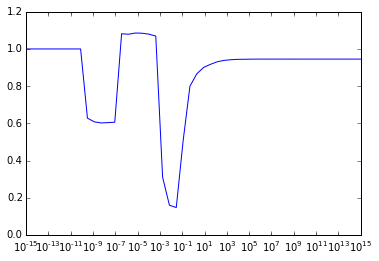

In [211]:
plot(all_gammas, values)
xscale('log')
#yscale('log')

In [151]:
print values

[  8.25153299e+14   2.01486292e+14   4.92048272e+13   1.20161052e+13
   2.93439289e+12   7.16594319e+11   1.74996139e+11   4.27349904e+10
   1.04361158e+10   2.54855918e+09   6.22375978e+08   1.51991813e+08
   3.71215020e+07   9.06956291e+06   2.21913290e+06   5.46231595e+05
   1.37741046e+05   3.81456449e+04   1.43678579e+04   9.67539573e+03
   9.28544792e+03   9.14996847e+03   9.05449559e+03   9.03833655e+03
   9.03832742e+03   9.03832742e+03   9.03832742e+03   9.03832742e+03
   9.03832742e+03   9.03832742e+03   9.03832742e+03   9.03832742e+03
   9.03832742e+03   9.03832742e+03   9.03832742e+03   9.03832742e+03
   9.03832742e+03   9.03832742e+03   9.03832742e+03   9.03832742e+03
   9.03832742e+03   9.03832742e+03   9.03832742e+03   9.03832742e+03
   9.03832742e+03   9.03832742e+03   9.03832742e+03   9.03832742e+03
   9.03832742e+03   9.03832742e+03]


SyntaxError: invalid syntax (<ipython-input-2-6c2f322ce20b>, line 1)